I want to analyze changes over time in the MOT GTFS feed. 

Agenda:
1. [Get data](#Get-the-data)

3. [Tidy](#Tidy-it-up)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ftplib import FTP
import datetime
import re
import zipfile
import os

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 5) # set default size of plots

sns.set_style("white")
sns.set_context("talk")
sns.set_palette('Set2', 10)

## Get the data
There are two options - TransitFeeds and the workshop's S3 bucket.

In [2]:
#!aws s3 cp s3://s3.obus.hasadna.org.il/2018-04-25.zip data/gtfs_feeds/2018-04-25.zip

## Tidy it up
Again I'm using [partridge](https://github.com/remix/partridge/tree/master/partridge) for filtering on dates, and then some tidying up and transformations.

In [7]:
from gtfs_utils import *

TARIFF_FILE_NAME = 'Tariff.zip'
TARIFF_TXT_NAME = 'Tariff.txt'
TARIFF_TO_REFORM_ZONE = 'StationToReformZone.txt'
local_tariff_path = 'data/sample/tariff.zip' 

In [ ]:
#conn = ftp_connect()
#get_ftp_file(conn, file_name = TARIFF_FILE_NAME, local_zip_path = local_tariff_path )

In [8]:
# not a true csv, so we need to jiggle it a bit
cols = ['ShareCode','ShareCodeDesc','ZoneCodes','Daily','Weekly','Monthly','FromDate','ToDate', 'EXTRA']
reform_cols = ['StationId', 'ReformZoneCode','FromDate','ToDate', 'EXTRA']
with zipfile.ZipFile(local_tariff_path) as zf:
    tariff_df = (pd.read_csv(zf.open(TARIFF_TXT_NAME), header=None, skiprows=[0], names = cols)
                .drop(columns = ['EXTRA']))
    reform_df = (pd.read_csv(zf.open(TARIFF_TO_REFORM_ZONE), header=None, skiprows=[0], names = reform_cols)
                 .drop(columns = ['EXTRA']))

    
# remove ShareCodes which contain multiple zones  e.g. גוש דן מורחב
tariff_df = (tariff_df[~ tariff_df.ZoneCodes.str.contains(';')]
             .rename(columns = {'ShareCodeDesc': 'zone_name',
                               'ZoneCodes': 'zone_id'}))
rs = reform_df[['StationId', 'ReformZoneCode']].drop_duplicates().applymap(str).set_index('StationId').iloc[:,0]

ts = (tariff_df[['zone_id', 'zone_name']].drop_duplicates().set_index('zone_id').iloc[:,0])
zones = rs.map(ts).reset_index().rename(columns={'StationId': 'stop_code', 'ReformZoneCode':'zone_name'})

In [9]:
import partridge as ptg

def get_partridge_feed(zip_path, date):
    service_ids_by_date = ptg.read_service_ids_by_date(zip_path)
    service_ids = service_ids_by_date[date]

    feed = ptg.feed(zip_path, view={
        'trips.txt': {
            'service_id': service_ids,
        },
    })
    return feed
    
def to_timedelta(df):
    '''
    Turn time columns into timedelta dtype
    '''
    cols = ['arrival_time', 'departure_time']
    numeric = df[cols].apply(pd.to_timedelta, unit='s')
    df = df.copy()
    df[cols] = numeric
    return df

def get_tidy_feed_df(feed, zones):
    s = feed.stops
    r = feed.routes
    t = (feed.trips
         .assign(route_id=lambda x: pd.Categorical(x['route_id'])))
    f = (feed.stop_times[['trip_id', 'departure_time', 'arrival_time', 'stop_id', 'stop_sequence']]
         .merge(s[['stop_id', 'stop_name', 'stop_lat', 'stop_lon', 'stop_code']], on='stop_id')
         # Much faster joins and slices with Categorical dtypes
         .merge(zones, how='left')
         .assign(zone_name=lambda x: pd.Categorical(x['zone_name']))
         .merge(t[['trip_id', 'route_id', 'direction_id']], on='trip_id')
         .merge(r[['route_id', 'route_short_name', 'route_long_name']], on='route_id')
         .assign(route_id=lambda x: pd.Categorical(x['route_id']))
         .pipe(to_timedelta)
        )
    return f

In [ ]:
LOCAL_ZIP_PATH = 'data/gtfs_feeds/2018-02-01.zip' 

In [ ]:
feed = get_partridge_feed(LOCAL_ZIP_PATH, datetime.date(2018,2 , 1))



In [5]:
f = get_tidy_feed_df(feed, zones)

NameError: name 'get_tidy_feed_df' is not defined

In [87]:
danwed = f25[f25.zone_name=="גוש דן"].trip_id.nunique() - f2[f2.zone_name=="גוש דן"].trip_id.nunique()
danthu = f26[f26.zone_name=="גוש דן"].trip_id.nunique() - f3[f3.zone_name=="גוש דן"].trip_id.nunique()
haiwed = f25[f25.zone_name=="סובב חיפה"].trip_id.nunique() - f2[f2.zone_name=="סובב חיפה"].trip_id.nunique()
haithu = f26[f26.zone_name=="סובב חיפה"].trip_id.nunique() - f3[f3.zone_name=="סובב חיפה"].trip_id.nunique()
akowed = f25[f25.zone_name=="עכו"].trip_id.nunique() - f2[f2.zone_name=="עכו"].trip_id.nunique()
akothu = f26[f26.zone_name=="עכו"].trip_id.nunique() - f3[f3.zone_name=="עכו"].trip_id.nunique()
nahwed = f25[f25.zone_name=="נהריה"].trip_id.nunique() - f2[f2.zone_name=="נהריה"].trip_id.nunique()
nahthu = f26[f26.zone_name=="נהריה"].trip_id.nunique() - f3[f3.zone_name=="נהריה"].trip_id.nunique()

In [91]:
netwed = f25[f25.zone_name=="נתניה"].trip_id.nunique() - f2[f2.zone_name=="נתניה"].trip_id.nunique()
netthu = f26[f26.zone_name=="נתניה"].trip_id.nunique() - f3[f3.zone_name=="נתניה"].trip_id.nunique()

In [92]:
print('Gush Dan Wed: %.2f' % (danwed / f25[f25.zone_name=="גוש דן"].trip_id.nunique()))
print('Gush Dan Thu: %.2f' % (danthu / f26[f26.zone_name=="גוש דן"].trip_id.nunique()))
print('Haifa Wed: %.2f' % (haiwed / f25[f25.zone_name=="סובב חיפה"].trip_id.nunique()))
print('Haifa Thu: %.2f' % (haithu / f26[f26.zone_name=="סובב חיפה"].trip_id.nunique()))
print('Akko Wed: %.2f' % (akowed / f25[f25.zone_name=="עכו"].trip_id.nunique()))
print('Akko Thu: %.2f' % (akothu / f26[f26.zone_name=="עכו"].trip_id.nunique()))
print('Nahariya Wed: %.2f' % (nahwed / f25[f25.zone_name=="נהריה"].trip_id.nunique()))
print('Nahariya Thu: %.2f' % (nahthu / f26[f26.zone_name=="נהריה"].trip_id.nunique()))
print('Netanya Wed: %.2f' % (netwed / f25[f25.zone_name=="נתניה"].trip_id.nunique()))
print('Netanya Thu: %.2f' % (netthu / f26[f26.zone_name=="נתניה"].trip_id.nunique()))


Gush Dan Wed: 0.03
Gush Dan Thu: 0.06
Haifa Wed: 0.04
Haifa Thu: 0.16
Akko Wed: 0.16
Akko Thu: 0.20
Nahariya Wed: 0.13
Nahariya Thu: 0.16
Netanya Wed: 0.02
Netanya Thu: 0.07


In [73]:
f26 = get_tidy_feed_df(feed26, zones)

In [23]:
#f = get_tidy_feed_df(feed, zones)
f2 = get_tidy_feed_df(feed2, zones)
f2.head()

,trip_id,departure_time,arrival_time,stop_id,stop_sequence,stop_name,stop_lat,stop_lon,stop_code,zone_name,route_id,direction_id,route_short_name,route_long_name
0,32046792_010518,21:36:00,21:36:00,37318,1,ירושלים מלחה,31.747801,35.188216,17078,סובב ירושלים,22707,1,NaN,ירושלים מלחה-ירושלים<->תל אביב מרכז-תל אביב יפו
1,32046792_010518,22:18:00,22:18:00,37322,2,בית שמש,31.757821,34.989515,17074,אזור בית שמש,22707,1,NaN,ירושלים מלחה-ירושלים<->תל אביב מרכז-תל אביב יפו
2,32046792_010518,22:45:00,22:45:00,37336,3,רמלה,31.928809,34.877304,17060,גוש דן,22707,1,NaN,ירושלים מלחה-ירושלים<->תל אביב מרכז-תל אביב יפו
3,32046792_010518,22:49:00,22:49:00,37338,4,לוד,31.945234,34.875081,17058,גוש דן,22707,1,NaN,ירושלים מלחה-ירושלים<->תל אביב מרכז-תל אביב יפו
4,32046792_010518,22:55:00,22:55:00,37334,5,לוד-גני אביב,31.966977,34.878790,17062,גוש דן,22707,1,NaN,ירושלים מלחה-ירושלים<->תל אביב מרכז-תל אביב יפו


In [59]:
f3 = get_tidy_feed_df(feed3, zones)

In [24]:
rcmp = pd.concat([feed26.trips.route_id.value_counts(), feed3.trips.route_id.value_counts()], axis=1, keys=['feed26', 'feed3'])

rcmp['dif'] = rcmp.feed26.subtract(rcmp.feed3)
pd.concat((rcmp, feed26.routes.set_index('route_id')[['route_short_name', 'route_long_name']]), axis=1).sort_values(by='dif', ascending=False).head(50)

,feed26,feed3,dif,route_short_name,route_long_name
15729,117.0,55.0,62.0,2,אבא שאול/איסוף-ביתר עילית<->דרך הרמ''ז/מפעל הש...
15730,116.0,55.0,61.0,2,דרך הרמז/סדיגורא-ביתר עילית<->אבא שאול/הורדה-ב...
10516,116.0,67.0,49.0,5,בית כנסת/הרב שך-ביתר עילית<->בית כנסת/הרב שך-ב...
10811,116.0,69.0,47.0,68,האוניברסיטה העברית הר הצופים-ירושלים<->האונ' ה...
10944,93.0,56.0,37.0,6,קדושת לוי/ברוק-ביתר עילית<->בית כנסת/הרב שך-בי...
10943,92.0,56.0,36.0,6,בית כנסת/הרב שך-ביתר עילית<->קדושת לוי/ברוק-בי...
10252,68.0,33.0,35.0,59,ביטוח לאומי-ירושלים<->וינוגרד/זווין-ירושלים-1#
2117,112.0,77.0,35.0,3,ת. מרכזית נתניה-נתניה<->ת. מרכזית נתניה-נתניה-3#
1130,95.0,61.0,34.0,62,בן ציון גליס/צבי ברגמן-פתח תקווה<->מסוף שניידר...
12406,87.0,54.0,33.0,15,האומן/ברעם-ירושלים<->בנייני האומה-ירושלים-2#


In [32]:
f.shape

(3211725, 14)

In [15]:
se = (feed.stop_times.groupby(['trip_id'])
     .agg({'departure_time': 'min',
          'arrival_time': 'max'})
     .pipe(to_timedelta)
     .sort_values(['arrival_time', 'departure_time']))
se.head()

,departure_time,arrival_time
trip_id,,
31908288_300418,00:00:00,00:11:34
31134614_300418,00:00:00,00:11:54
26329437_300418,00:00:00,00:12:17
13660343_300418,00:05:00,00:12:37
25359099_300418,00:05:00,00:17:00


In [25]:
se2 = (feed2.stop_times.groupby(['trip_id'])
     .agg({'departure_time': 'min',
          'arrival_time': 'max'})
     .pipe(to_timedelta)
     .sort_values(['arrival_time', 'departure_time']))
se2.head()

,departure_time,arrival_time
trip_id,,
31908288_010518,0 days,00:11:34
31134614_010518,0 days,00:11:54
31594862_010518,0 days,00:28:14
14590733_010518,0 days,00:29:09
14590851_010518,0 days,00:33:32


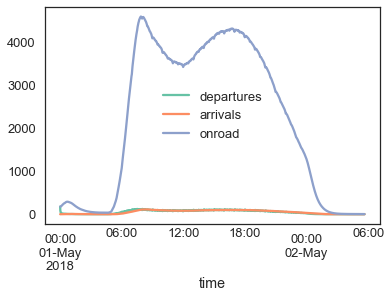

In [28]:
departures = pd.Series(1, se.departure_time).resample('1Min').sum()
arrivals =  pd.Series(1, se.arrival_time).resample('T').sum()
onroad = pd.concat([pd.Series(1, se.departure_time),  # departed add 1
                           pd.Series(-1, se.arrival_time)  # arrived substract 1
                           ]).resample('1Min').sum().cumsum().ffill()
df = (pd.concat([departures, arrivals, onroad], axis=1).reset_index()
        .rename(columns={'index': 'time', 0:'departures', 1:'arrivals', 2:'onroad'}))
idx = pd.DatetimeIndex(df.time+datetime.datetime(2018, 5, 1))

(df.assign(time=idx)
 .set_index('time')
 .resample('1min').sum()
 .ewm(span=60)
 .mean()
 .plot())

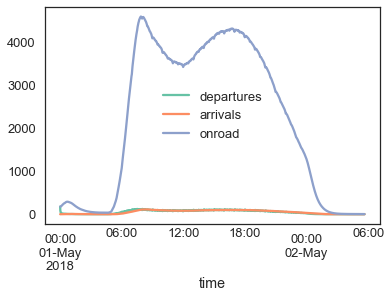

In [30]:
departures2 = pd.Series(1, se2.departure_time).resample('1Min').sum()
arrivals2 =  pd.Series(1, se2.arrival_time).resample('T').sum()
onroad2 = pd.concat([pd.Series(1, se2.departure_time),  # departed add 1
                           pd.Series(-1, se2.arrival_time)  # arrived substract 1
                           ]).resample('1Min').sum().cumsum().ffill()
df2 = (pd.concat([departures, arrivals, onroad], axis=1).reset_index()
        .rename(columns={'index': 'time', 0:'departures', 1:'arrivals', 2:'onroad'}))
#idx = pd.DatetimeIndex(df.time+datetime.datetime(2018, 5, 1))

(df2.assign(time=idx)
 .set_index('time')
 .resample('1min').sum()
 .ewm(span=60)
 .mean()
 .plot())

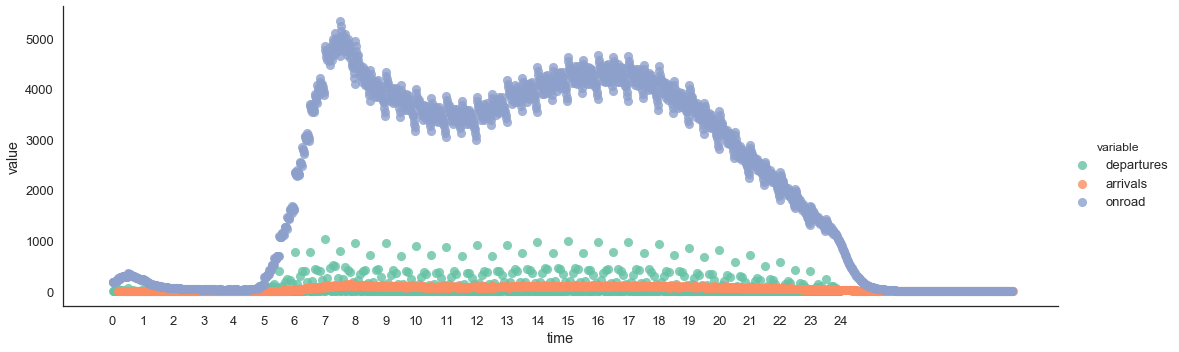

In [17]:
def to_numeric(df):
    '''
    Turn timedelta columns into numeric dtype
    '''
    cols = ['time']
    numeric = df[cols].apply(pd.to_numeric)
    df = df.copy()
    df[cols] = numeric
    return df

# we have to convert to numeric in order to use time in lmplot
melted_df = (df.pipe(to_numeric)
             .melt(id_vars=['time']))
g = sns.lmplot(x="time", y="value", hue="variable", data=melted_df, 
           size=5, aspect=3, line_kws={'linewidth': 0}, ci=None)
g.set(xticks=np.arange(25)*60*60*1e9, xticklabels=np.arange(25))

## GTFSTK

In [25]:
import gtfstk as gt
import shapely.geometry as sg

In [26]:
# List feed

gt.list_gtfs(LOCAL_ZIP_PATH2)

,file_name,file_size
0,agency.txt,2027
1,calendar.txt,1670513
2,fare_attributes.txt,8635
3,fare_rules.txt,12264501
4,routes.txt,975122
5,shapes.txt,219980322
6,stop_times.txt,972809367
7,stops.txt,3948697
8,translations.txt,4383402
9,trips.txt,36304514


In [33]:
# Read and print feed

feed = gt.read_gtfs(LOCAL_ZIP_PATH2, dist_units='m')
print(feed)

* agency --------------------
	  agency_id agency_name                      agency_url agency_timezone  \
0         2  רכבת ישראל           http://www.rail.co.il  Asia/Jerusalem   
1         3         אגד          http://www.egged.co.il  Asia/Jerusalem   
2         4  אגד תעבורה  http://www.egged-taavura.co.il  Asia/Jerusalem   
3         5          דן            http://www.dan.co.il  Asia/Jerusalem   
4         6       ש.א.מ    http://www.nazareth-unbs.com  Asia/Jerusalem   

  agency_lang agency_phone agency_fare_url  
0          he          NaN             NaN  
1          he          NaN             NaN  
2          he          NaN             NaN  
3          he          NaN             NaN  
4          he          NaN             NaN  
* calendar --------------------
	  service_id  sunday  monday  tuesday  wednesday  thursday  friday  saturday  \
0   59186130       1       1        1          1         1       1         0   
1   59191707       1       1        1          1       

In [34]:
feed.describe()

,indicator,value
0,agencies,"[רכבת ישראל, אגד, אגד תעבורה, דן, ש.א.מ, נסיעו..."
1,timezone,Asia/Jerusalem
2,start_date,20180501
3,end_date,20180630
4,num_routes,7761
5,num_trips,512583
6,num_stops,27795
7,num_shapes,7658
8,sample_date,20180510
9,num_routes_active_on_sample_date,6734


In [30]:
# Validate

feed.validate()

,type,message,table,rows
0,warning,Unrecognized column agency_id,fare_attributes,[]
1,warning,"Repeated pair (route_short_name, route_long_name)",routes,"[15, 17, 18, 25, 26, 29, 30, 31, 33, 47, 50, 7..."
2,warning,Stop has no stop times,stops,"[625, 1928, 2840, 2841, 3129, 3642, 3789, 4088..."


In [35]:
# Compute trip stats

trip_stats = feed.compute_trip_stats()
trip_stats.head().T

,170643,170617,170644,170618,170619
trip_id,27727651_010518,27727521_010518,27727652_010518,27727522_010518,27727523_010518
route_id,1,1,1,1,1
route_short_name,1,1,1,1,1
route_type,3,3,3,3,3
direction_id,0,0,0,0,0
shape_id,94990,94990,94990,94990,94990
num_stops,19,19,19,19,19
start_time,05:05:00,05:10:00,05:30:00,05:40:00,06:00:00
end_time,05:24:44,05:29:44,05:49:44,05:59:44,06:19:44
start_stop_id,38725,38725,38725,38725,38725


In [36]:
# Add shape_dist_traveled column to stop times

feed = feed.append_dist_to_stop_times(trip_stats)
feed.stop_times.head().T

,5895939,5895940,5895941,5895942,5895943
trip_id,10021427_050518,10021427_050518,10021427_050518,10021427_050518,10021427_050518
arrival_time,00:00:00,00:01:34,00:03:26,00:05:21,00:06:22
departure_time,00:00:00,00:01:34,00:03:26,00:05:21,00:06:22
stop_id,36133,2356,3869,2357,3803
stop_sequence,1,2,3,4,5
pickup_type,0,0,0,0,0
drop_off_type,1,1,1,1,1
shape_dist_traveled,34.3139,502.771,1841.84,2696,3382.7


In [37]:
# Choose study dates

#week = feed.get_first_week()
#dates = [week[4], week[6]]  # First Friday and Sunday
dates = ['20180502', '20180503']

In [38]:
route_stats = feed.compute_route_stats(trip_stats, dates )
route_stats.head().T

,0,1,2,3,4
route_id,1,10,10000,10001,10002
route_short_name,1,4,91,91,92
route_type,3,3,3,3,3
num_trips,26,35,1,5,1
num_trip_starts,26,35,1,5,1
num_trip_ends,26,35,1,5,1
is_loop,0,0,0,0,0
is_bidirectional,0,0,0,0,0
start_time,05:10:00,06:05:00,08:00:00,13:00:00,07:30:00
end_time,21:54:44,22:48:36,08:17:31,16:51:42,07:53:03


In [40]:
feed_lw = gt.read_gtfs(LOCAL_ZIP_PATH3, dist_units='m')
trip_stats_lw = feed_lw.compute_trip_stats()
dates_lw = ['20180425', '20180426']
route_stats_lw = feed_lw.compute_route_stats(trip_stats_lw, dates_lw )
route_stats_lw.head()

,route_id,route_short_name,route_type,num_trips,num_trip_starts,num_trip_ends,is_loop,is_bidirectional,start_time,end_time,...,mean_headway,peak_num_trips,peak_start_time,peak_end_time,service_distance,service_duration,service_speed,mean_trip_distance,mean_trip_duration,date
0,1,1,3.0,26.0,26.0,26.0,0.0,0.0,05:10:00,21:54:44,...,37.8125,1.0,05:10:00,05:29:44,182416.0,8.551111,21332.432432,7016.0,0.328889,20180425
1,10,4,3.0,35.0,35.0,35.0,0.0,0.0,06:05:00,22:48:36,...,28.0000,2.0,15:55:00,16:03:36,261100.0,10.850000,24064.516129,7460.0,0.310000,20180425
2,10000,91,3.0,1.0,1.0,1.0,0.0,0.0,08:00:00,08:17:31,...,NaN,1.0,08:00:00,08:17:31,6326.0,0.291944,21668.506185,6326.0,0.291944,20180425
3,10001,91,3.0,5.0,5.0,5.0,0.0,0.0,13:00:00,16:51:42,...,52.5000,2.0,13:00:00,13:21:42,41880.0,1.808333,23159.447005,8376.0,0.361667,20180425
4,10002,92,3.0,1.0,1.0,1.0,0.0,0.0,07:30:00,07:53:03,...,NaN,1.0,07:30:00,07:53:03,7175.0,0.384167,18676.789588,7175.0,0.384167,20180425


In [63]:
(pd.concat((route_stats_lw[(route_stats_lw.date=='20180426') & (route_stats_lw.num_trips>30)].set_index('route_id')[['route_short_name', 'num_trips', 'mean_headway']], 
route_stats[route_stats.date=='20180503'].set_index('route_id')[['num_trips', 'mean_headway']]), axis=1, keys=['last_week', 'this_week'])
 .dropna()
 .assign(dif = lambda x: x.iloc[:,2] - x.iloc[:, 4])
 .sort_values(by=[('dif')], ascending=True)
)

last_week                        this_week               \
      route_short_name num_trips mean_headway num_trips mean_headway   
2184                22      34.0    20.275862      15.0    62.000000   
1397                 4      40.0    24.482759      15.0    64.090909   
1398                 3      40.0    24.642857      15.0    62.727273   
9623                 1      37.0    28.750000      16.0    64.000000   
9622                 1      37.0    30.000000      16.0    64.090909   
3768                37      47.0    19.459459      22.0    53.076923   
20391               53      33.0    32.727273      16.0    66.000000   
20317               52      34.0    32.727273      16.0    66.000000   
20785               54      31.0    32.727273      16.0    66.000000   
17427               63      32.0    32.727273      16.0    65.454545   
20392               53      33.0    32.727273      17.0    65.454545   
20786               54      31.0    32.727273      17.0    65.454545   
20318               52      34.0    32.727273      17.0    65.454545   
17428               63      32.0    31.363636      16.0    63.000000   
16877              146      31.0    30.000000      16.0    61.500000   
3593                 9      37.0    28.541667      22.0    60.000000   
19671              500      31.0    29.782609      19.0    60.000000   
16876              146      32.0    30.000000      17.0    60.000000   
3600                10      32.0    30.000000      17.0    60.000000   
17943              307      35.0    30.000000      18.0    60.000000   
17944              307      35.0    30.000000      18.0    60.000000   
19672              500      31.0    30.000000      19.0    56.666667   
14068                5      40.0    23.000000      18.0    48.928571   
1575               332      40.0    20.588235      16.0    45.714286   
10946                3      31.0    33.000000      25.0    57.500000   
12024                4      31.0    30.652174      19.0    54.230769   
9624                 2      45.0    25.961538      23.0    48.214286   
19760               21      35.0    29.791667      23.0    51.071429   
1275                10      43.0    24.000000      23.0    45.000000   
16277               88      56.0    19.459459      29.0    40.000000   
...                ...       ...          ...       ...          ...   
17525               18      52.0    18.000000      52.0    18.000000   
17526               18      57.0    17.142857      57.0    17.142857   
17531               22      72.0    13.396226      72.0    13.396226   
17532               22      74.0    12.909091      74.0    12.909091   
17537               24      59.0    15.444444      59.0    15.444444   
17554                9      98.0     9.386667      98.0     9.386667   
17644                6      76.0    12.631579      76.0    12.631579   
17545               25      61.0    14.893617      61.0    14.893617   
17546               25      58.0    16.250000      58.0    16.250000   
17547               34      55.0    18.000000      55.0    18.000000   
17548               34      56.0    17.875000      56.0    17.875000   
17842                2      37.0    30.000000      37.0    30.000000   
17553                9      91.0     8.743243      91.0     8.743243   
17934               13      32.0    31.363636      32.0    31.363636   
13580               40      31.0    30.000000      31.0    29.954545   
5650                45      39.0    29.333333      39.0    29.250000   
19630               47      31.0    27.600000      31.0    27.480000   
1100                23      48.0    19.583333      49.0    19.459459   
15540               15      51.0    20.142857      51.0    20.000000   
19741              947      31.0    28.958333      31.0    28.750000   
9454               132      34.0    27.600000      33.0    27.240000   
16874              18א      33.0    29.347826      34.0    28.958333   
993                 69      31.0    29.375000      32

In [66]:
feed26.routes[feed26.routes.route_id=='2184']

,route_id,agency_id,route_short_name,route_long_name,route_desc,route_type,route_color
2356,2184,4,22,ת. מרכזית נתניה/רציפים-נתניה<->ת. מרכזית נתניה...,19022-3-#,3,NaN
